In [163]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import anndata as ann
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

## Reading in the Data
The data is read in from a *h5ad file* and outputted as an annotated dataset

In [117]:
data = ann.read_h5ad('combinedCells.h5ad')

## Reading in the Labels
The labels (schizophrenic vs. wild type) are stored within the anndata object. Furthermore, they are stored in "obs" under the subcategory "phenotype".

In [118]:
labels = data.obs["Phenotype"].to_numpy()[:100000]

## Formatting for Analysis
For starters, we need to extract the features from the dataset into a numpy array (which will be used to process and analyze the data). Once we have the features, we can then begin to encode the labels to either 0 or 1 such that TensorFlow can understand the labels in integer form (currently in a string).

In [119]:
data = data.to_df().to_numpy()[:100000]
encoder = LabelEncoder()
enc_labels = encoder.fit_transform(labels)

## Autoencoder as Dimensionality Reduction
The dataset is extensive and includes numerous features to analyze. To decrease the computational complexity, we will be reducing the data dimesnions to a latent vector of size 64. Each observation will be fed into the autoencoder and then created by encoding. The decoder will not be used for this analysis.

In [120]:
class Autoencoder(keras.Model):
    def __init__(self, data_dim=(3,3)):
        super(Autoencoder, self).__init__()
        self.data_dim = data_dim[1]
        self.encoder = keras.Sequential([
            keras.Input(self.data_dim),
            keras.layers.Dense(1024, activation='relu'),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(256, activation='relu'),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(64, activation='relu')
        ])
        self.decoder = keras.Sequential([
            keras.layers.Dense(self.data_dim, activation='sigmoid'),
#             keras.layers.Reshape(data_dim[1])
        ])

    def call(self, x):
        encoded = self.encoder(x)
        new_data = self.decoder(encoded)
        return new_data


## Fully Connected Feedforward Neural Network as a Binary Classifier
The data can take any dimensional size. The input of the data will then be condense by a series of hidden layers (5) that will be outputted to one of two classes using the activation of softmax. This data can take autoencoded and non-autoencoded data. 

In [121]:
class NeuralNetwork(keras.Model):
    def __init__(self, data_dim = (1,1)):
        super(NeuralNetwork, self).__init__()
        self.data_dim = data_dim[1]
        self.model = keras.Sequential([
            keras.Input(self.data_dim),
            keras.layers.Dense(1024, activation='relu'),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(256, activation='relu'),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(2, activation='softmax')
        ]) 
    def call(self, x):
        model = self.model(x)
        return model

## Building the Models
Now we need to call the functions above, we will then get a proper model with the correct data input that we want. For optimization methods, we will be using Adam for weight optimization. Loss will be calcuated in binary crossentropy since this is a classification problem.

In [122]:
autoencoder = Autoencoder(data.shape)
model = NeuralNetwork(data.shape)

autoencoder.compile(optimizer='adam', loss="binary_crossentropy")

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

## Creating the Train and Test Set of Data
The datasets need to be created, so we are going to use sklearns train_test_split function which makes a train set of 80% of the data and 20% for the test set. 

In [123]:
x_train, x_test, y_train, y_test = train_test_split(data, enc_labels)

## Let's Begin Fitting the Models
First let us begin by fitting the autoencoder to the data. The dimesionality is large, so lets give the autoencoder more rounds (epochs) to find the best latent vector representation of the data

In [124]:
history = autoencoder.fit(x_train, x_train,
                         epochs = 5,
                         validation_data=(x_test, x_test))

Epoch 1/5
2344/2344 [==============================] - 275s 116ms/step - loss: -5262783037521588.0000 - val_loss: -209732031976833024.0000
Epoch 2/5
2344/2344 [==============================] - 790s 337ms/step - loss: -859496223990992896.0000 - val_loss: -6030148926990974976.0000
Epoch 3/5
2344/2344 [==============================] - 260s 111ms/step - loss: -11271307980129470464.0000 - val_loss: -38357426307151691776.0000
Epoch 4/5
2344/2344 [==============================] - 341s 146ms/step - loss: -57030010234250395648.0000 - val_loss: -140752406529093664768.0000
Epoch 5/5
2344/2344 [==============================] - 1614s 689ms/step - loss: -188395461460811317248.0000 - val_loss: -386387631852018991104.0000


## Let's Make a Model with All 17658 Features
As a baseline model, lets run the model to see if the Neural Network can accurately classify the dataset with all the features (we will dimensionality reduce later and compare)

In [125]:
history_model = model.fit(x_train, y_train,
                epochs=5,
                validation_data=(x_test, y_test))

Epoch 1/5
2344/2344 [==============================] - 228s 97ms/step - loss: 0.4660 - accuracy: 0.8118 - val_loss: 0.2080 - val_accuracy: 0.9170
Epoch 2/5
2344/2344 [==============================] - 225s 96ms/step - loss: 0.1223 - accuracy: 0.9532 - val_loss: 0.2235 - val_accuracy: 0.9088
Epoch 3/5
2344/2344 [==============================] - 598s 255ms/step - loss: 0.0798 - accuracy: 0.9705 - val_loss: 0.1915 - val_accuracy: 0.9313
Epoch 4/5
2344/2344 [==============================] - 231s 98ms/step - loss: 0.0554 - accuracy: 0.9795 - val_loss: 0.2014 - val_accuracy: 0.9321
Epoch 5/5
2344/2344 [==============================] - 224s 96ms/step - loss: 0.0357 - accuracy: 0.9878 - val_loss: 0.2255 - val_accuracy: 0.9382


## Finding Genes Specific to MSN (D1/D2)
For our graduate analysis, we chose to dive deeper into the Medium Spiny Neurons (MSN). For the project, we chose both the D1 and D2 cell types. The dataset is classifying between Schizophrenic and Wild type individuals. We would like to further analyze the dataset to see if our specific genes of interest associated with the most positively (FHIT) and negatively coorelated peaks (ANKS1B) shows a good enough difference between Schizophrenia and WT.

We can also use both features to see if this will give a better score compared to just using the most positively and negatively coorelated peak to Social Group Size.

In [231]:
# read in the genes
genes = pd.read_csv("combinedCells_names.csv").to_numpy().reshape(1, -1)[0]

# find the index for FHIT and ANKS1B in genes columns
FHIT_idx = np.where(genes == 'FHIT')
ANKS1B_idx = np.where(genes == 'ANKS1B')

# use the index to create individual datasets for the genes
FHIT_only_dataset = data[:, FHIT_idx].reshape(len(data), 1)
ANKS1B_only_dataset = data[:, ANKS1B_idx].reshape(len(data), 1)
both_dataset = data[:, [FHIT_idx, ANKS1B_idx]].reshape(len(data), 2)

## Creating Training and Testing Data for Each Dataset
Since we have created new datasets, we will need to split into a train and test set for each respective dataset.

In [232]:
FHIT_xtrain, FHIT_xtest, FHIT_ytrain, FHIT_ytest = train_test_split(FHIT_only_dataset, enc_labels)
ANKS1B_xtrain, ANKS1B_xtest, ANKS1B_ytrain, ANKS1B_ytest = train_test_split(ANKS1B_only_dataset, enc_labels)
both_xtrain, both_xtest, both_ytrain, both_ytest = train_test_split(both_dataset, enc_labels)

## Logisitic Regression as a Classifier
Since these datasets will be low in dimensionality, it would be unneccesary to run a neural network. Therefore, we can use an easy logisitic regressors to predict the phenotype of the given observation.

We will need to create three different models to distinguish the three different datasets.

In [233]:
FHIT_model = LogisticRegression()
ANKS1B_model = LogisticRegression()
both_model = LogisticRegression()

## Fit the models to the data
The model needs fit for each dataset. Fitting is a method of training, so we only want the model to see the training dataset so we can validate with the test set.

In [234]:
FHIT_model.fit(FHIT_xtrain, FHIT_ytrain)
ANKS1B_model.fit(ANKS1B_xtrain, ANKS1B_ytrain)
both_model.fit(both_xtrain, both_ytrain)

LogisticRegression()

## Score of Models
The score function will determine how well we are fitting the model to the data. In this case, we are only using a binary classifier, which means random chance will be a score of 0.50. The best score would be a 1.0

In [235]:
print("Score of FHIT only:", FHIT_model.score(FHIT_xtest, FHIT_ytest))
print("Score of ANKS1B only:", ANSK1B_model.score(ANKS1B_xtest, ANKS1B_ytest))
print("Score of both genes:", both_model.score(both_xtest, both_ytest))

Score of FHIT only: 0.59056
Score of ANKS1B only: 0.5892
Score of both genes: 0.5894


## ROC Metric
The ROC curve is using the True and False positive rates to show how well the model is predicitng the dataset. A perfect model will appear to exponentially increase to 1 intially and stay there, whereas a bad model (random chance) will give a straight line. Let's build a function to plot each of the models ROC (and PRC for later).

In [236]:
def plotPRC(x, y, model, label):
    precision, recall, thresh = precision_recall_curve(y, model.predict_proba(x)[:,1])
    plt.plot(recall, precision, label = label)
    
def plotROC(x, y, model, label):
    fpr, tpr, thresh = roc_curve(y, model.predict_proba(x)[:,1])
    plt.plot(fpr, tpr, label = label)

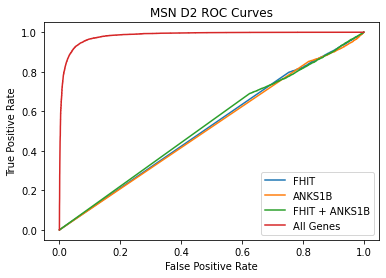

In [237]:
# plotting roc
plotROC(FHIT_xtest, FHIT_ytest, FHIT_model, label = "FHIT")
plotROC(ANKS1B_xtest, ANKS1B_ytest, ANKS1B_model, label = "ANKS1B")
plotROC(both_xtest, both_ytest, both_model, label = "FHIT + ANKS1B")

fpr, tpr, thresh = roc_curve(y_test, model.predict(x_test)[:, 1])
plt.plot(fpr, tpr, label = "All Genes")

plt.legend(), plt.title("MSN D2 ROC Curves"), plt.ylabel("True Positive Rate"), plt.xlabel("False Positive Rate")
plt.show()

## Data Imbalance
When the data is imbalanced, meaning one label dominates another in number of observations, the ROC curve can be an imperfect measure of how well the model is performing. Let's first print how imbalanced our data is. Based on how imbalanced the data is, PRC is a better evaluator of the model.

In [ ]:
print("Percent Schizophrenia (1):", len(np.where(enc_labels==1)[0])/len(enc_labels))
print("Percent Wild Type (0):", len(np.where(enc_labels==0)[0])/len(enc_labels))

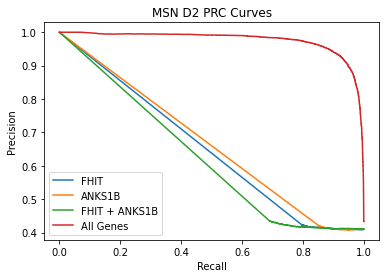

In [238]:
# plotting PRC
plotPRC(FHIT_xtest, FHIT_ytest, FHIT_model, label = "FHIT")
plotPRC(ANKS1B_xtest, ANKS1B_ytest, ANKS1B_model, label = "ANKS1B")
plotPRC(both_xtest, both_ytest, both_model, label = "FHIT + ANKS1B")

precision, recall, thresh = precision_recall_curve(y_test, model.predict(x_test)[:, 1])
plt.plot(recall, precision, label="All Genes")

plt.legend(), plt.title("MSN D2 PRC Curves"), plt.ylabel("Precision"), plt.xlabel("Recall")
plt.show()

## Now Let's Do the Same Thing, This Time with MSN D1
For MSN D1, we found the gene closes to the highest positive corrleated peak to be CNTN6 and the gene closest to the most negative correlated peak was LHFPL3

In [241]:
# find the index for CNTN6 and LHFPL3 in genes columns
CNTN6_idx = np.where(genes == 'CNTN6')
LHFPL3_idx = np.where(genes == 'LHFPL3')

# use the index to create individual datasets for the genes
CNTN6_only_dataset = data[:, CNTN6_idx].reshape(len(data), 1)
LHFPL3_only_dataset = data[:, LHFPL3_idx].reshape(len(data), 1)
both_dataset = data[:, [CNTN6_idx, LHFPL3_idx]].reshape(len(data), 2)

# create test/train datasets
CNTN6_xtrain, CNTN6_xtest, CNTN6_ytrain, CNTN6_ytest = train_test_split(CNTN6_only_dataset, enc_labels)
LHFPL3_xtrain, LHFPL3_xtest, LHFPL3_ytrain, LHFPL3_ytest = train_test_split(LHFPL3_only_dataset, enc_labels)
both_xtrain, both_xtest, both_ytrain, both_ytest = train_test_split(both_dataset, enc_labels)

# create a model
CNTN6_model = LogisticRegression()
LHFPL3_model = LogisticRegression()
both_model = LogisticRegression()

# fit to the new model
CNTN6_model.fit(CNTN6_xtrain, CNTN6_ytrain)
LHFPL3_model.fit(LHFPL3_xtrain, LHFPL3_ytrain)
both_model.fit(both_xtrain, both_ytrain)

# print the scores of the model
print("Score of CNTN6 only:", CNTN6_model.score(CNTN6_xtest, CNTN6_ytest))
print("Score of LHFPL3 only:", LHFPL3_model.score(LHFPL3_xtest, LHFPL3_ytest))
print("Score of both genes:", both_model.score(both_xtest, both_ytest))

Score of CNTN6 only: 0.5892
Score of LHFPL3 only: 0.59224
Score of both genes: 0.58292


## Plot the ROC and PRC of the MSN D1 Associated Genes

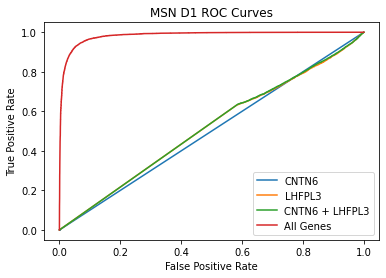

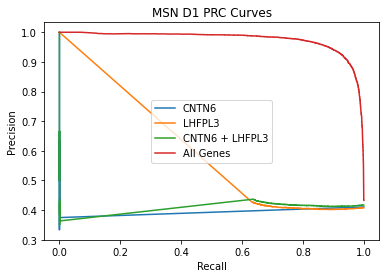

In [242]:
# plotting roc
plotROC(CNTN6_xtest, CNTN6_ytest, CNTN6_model, label = "CNTN6")
plotROC(LHFPL3_xtest, LHFPL3_ytest, LHFPL3_model, label = "LHFPL3")
plotROC(both_xtest, both_ytest, both_model, label = "CNTN6 + LHFPL3")

fpr, tpr, thresh = roc_curve(y_test, model.predict(x_test)[:, 1])
plt.plot(fpr, tpr, label = "All Genes")

plt.legend(), plt.title("MSN D1 ROC Curves"), plt.ylabel("True Positive Rate"), plt.xlabel("False Positive Rate")
plt.show()

# plotting PRC
plotPRC(CNTN6_xtest, CNTN6_ytest, CNTN6_model, label = "CNTN6")
plotPRC(LHFPL3_xtest, LHFPL3_ytest, LHFPL3_model, label = "LHFPL3")
plotPRC(both_xtest, both_ytest, both_model, label = "CNTN6 + LHFPL3")

precision, recall, thresh = precision_recall_curve(y_test, model.predict(x_test)[:, 1])
plt.plot(recall, precision, label="All Genes")

plt.legend(), plt.title("MSN D1 PRC Curves"), plt.ylabel("Precision"), plt.xlabel("Recall")
plt.show()

## Finding all Genes Associated with Top Peaks (Positive/Negative)
In our original analysis, we found 200 peaks correlated both positively and negatively with our trait (social group size). Above, we found that the analysis was not able to accurately classify since the score was roughly 0.55 which is just above random chance. Now we are going to find all the genes near the peaks (~300 genes for each) and run the following classifier using those datapoints.

In [225]:
# read in the file containing the genes that are associated with each of the correlations and cell type
posD1 = pd.read_csv("posD1_associatedGenes.txt", sep = "\t", header = None).to_numpy()[:,0]
posD2 = pd.read_csv("posD2_associatedGenes.txt", sep = "\t", header = None).to_numpy()[:,0]
negD1 = pd.read_csv("negD1_associatedGenes.txt", sep = "\t", header = None).to_numpy()[:,0]
negD2 = pd.read_csv("negD2_associatedGenes.txt", sep = "\t", header = None).to_numpy()[:,0]

# find the location where the genes are located in the dataset (NOTE: not all genes are inside the dataset)
posD1_idx = np.argwhere(np.isin(genes, posD1)).ravel()
posD2_idx = np.argwhere(np.isin(genes, posD2)).ravel()
negD1_idx = np.argwhere(np.isin(genes, negD1)).ravel()
negD2_idx = np.argwhere(np.isin(genes, negD2)).ravel()

# extract the data points using the indices found above
posD1_dataset = data[:,posD1_idx]
posD2_dataset = data[:,posD2_idx]
negD1_dataset = data[:,negD1_idx]
negD2_dataset = data[:,negD2_idx]

## Random Forest Classifier as the Model
With the entire dataset, we ran a neural network because each of the gene features are able to "interact" by creating weights within hidden layers to a given output. With the single gene, there is only a single feature to classify the samples which makes Logistic Regression a good fit. For this problem, we now have 300 genes and 100000 samples. We now have many features to split the data into two distinct classes, so choosing a random forest method works well for this problem. For our models, we are going to keep the preset (shallow) trees.

In [214]:
# create the model for each of the datasets
posD1_model = RandomForestClassifier()
posD2_model = RandomForestClassifier()
negD1_model = RandomForestClassifier()
negD2_model = RandomForestClassifier()

In [215]:
# split the data
pD1_xtrain, pD1_xtest, pD1_ytrain, pD1_ytest = train_test_split(posD1_dataset, enc_labels)
nD1_xtrain, nD1_xtest, nD1_ytrain, nD1_ytest = train_test_split(negD1_dataset, enc_labels)
pD2_xtrain, pD2_xtest, pD2_ytrain, pD2_ytest = train_test_split(posD2_dataset, enc_labels)
nD2_xtrain, nD2_xtest, nD2_ytrain, nD2_ytest = train_test_split(negD2_dataset, enc_labels)

In [216]:
# fit the model
posD1_model.fit(pD1_xtrain, pD1_ytrain)
posD2_model.fit(pD2_xtrain, pD2_ytrain)
negD1_model.fit(nD1_xtrain, nD1_ytrain)
negD2_model.fit(nD2_xtrain, nD2_ytrain)

RandomForestClassifier()

In [226]:
# print the scores of the model
print("Score of D1 Positive Coorelated Genes:", posD1_model.score(pD1_xtest, pD1_ytest))
print("Score of D2 Positive Coorelated Genes:", posD2_model.score(pD2_xtest, pD2_ytest))
print("Score of D1 Negative Coorelated Genes:", negD1_model.score(nD1_xtest, nD1_ytest))
print("Score of D2 Negative Coorelated Genes:", negD2_model.score(nD2_xtest, nD2_ytest))

Score of D1 Positive Coorelated Genes: 0.68204
Score of D2 Positive Coorelated Genes: 0.6774
Score of D1 Negative Coorelated Genes: 0.6692
Score of D2 Negative Coorelated Genes: 0.69364


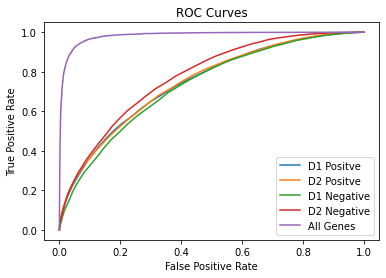

In [228]:
plotROC(pD1_xtest, pD1_ytest, posD1_model, label = "D1 Positve")
plotROC(pD2_xtest, pD2_ytest, posD2_model, label = "D2 Positve")
plotROC(nD1_xtest, nD1_ytest, negD1_model, label = "D1 Negative")
plotROC(nD2_xtest, nD2_ytest, negD2_model, label = "D2 Negative")
fpr, tpr, thresh = roc_curve(y_test, model.predict(x_test)[:, 1])
plt.plot(fpr, tpr, label = "All Genes")
plt.legend(), plt.title("ROC Curves"), plt.ylabel("True Positive Rate"), plt.xlabel("False Positive Rate")
plt.show()

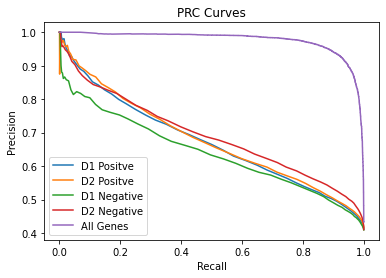

In [229]:
plotPRC(pD1_xtest, pD1_ytest, posD1_model, label = "D1 Positve")
plotPRC(pD2_xtest, pD2_ytest, posD2_model, label = "D2 Positve")
plotPRC(nD1_xtest, nD1_ytest, negD1_model, label = "D1 Negative")
plotPRC(nD2_xtest, nD2_ytest, negD2_model, label = "D2 Negative")

precision, recall, thresh = precision_recall_curve(y_test, model.predict(x_test)[:, 1])
plt.plot(recall, precision, label="All Genes")

plt.legend(), plt.title("PRC Curves"), plt.ylabel("Precision"), plt.xlabel("Recall")
plt.show()